In [1]:
import gensim
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import time

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mohitgupta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohitgupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.svm import SVC
from sklearn import tree

In [3]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [4]:
train_data = pd.read_csv("train.csv")

In [5]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True) 

In [ ]:
word2vec_model.similar_by_word("cancer")

In [6]:
def get_word2vec(description, model):
    description = str(description)
    description = description.lower()
    description = re.sub('[^a-zA-Z]', ' ', description )  
    description = re.sub(r'\s+', ' ', description)
    description_tokens = nltk.sent_tokenize(description)
    all_words = [nltk.word_tokenize(sent) for sent in description_tokens]
    for i in range(len(all_words)):  
        all_words[i] = [w for w in all_words[i] if w not in stopwords.words('english')]
    if len(all_words) > 0:
        all_words = all_words[0]
    avg_word2vec_words = np.zeros(300)
#     print (all_words)
    for word in all_words:
        if word in model:
            avg_word2vec_words += model[word]
        
    return avg_word2vec_words  

In [7]:
def convert_text_col_word2vec(column, model):
    col_vector_list = []
    for description in column:
        description_vector = get_word2vec(description, model)
        col_vector_list.append(description_vector)
    return np.array(col_vector_list)

In [8]:
def _run_nn(train_feature_matrix, train_label_matrix, test_feature_matrix):
    nn_clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(1500, 500), random_state=1)
    nn_train_feature_matrix = train_feature_matrix.astype(np.float64)
    nn_test_feature_matrix = test_feature_matrix.astype(np.float64)
    nn_clf.fit(nn_train_feature_matrix, train_label_matrix)
    nn_predictions = nn_clf.predict(nn_test_feature_matrix)
    return nn_predictions

In [9]:
def _run_svm(train_feature_matrix, train_label_matrix, test_feature_matrix):
    clf = SVC(gamma='auto')
    clf.fit(train_feature_matrix, train_label_matrix)
    predicted_labels = clf.predict(test_feature_matrix)
    return predicted_labels

In [10]:
def _run_dtree(train_feature_matrix, train_label_matrix, test_feature_matrix):
    dt_clf = tree.DecisionTreeClassifier()
    dt_clf = dt_clf.fit(train_feature_matrix, train_label_matrix)
    dt_predictions = dt_clf.predict(test_feature_matrix)
    return dt_predictions

In [11]:
def calculate_macro_f1_score(predictions, true_labels):
    true_positives = [0 for i in range(11)]
    false_positives = [0 for i in range(11)]
    false_negatives = [0 for i in range(11)]

    if len(predictions) != len(true_labels):
        print("bug in code, length of predictions should match length of true_labels")
        return None
    for i in range(len(predictions)):
        if predictions[i] == true_labels[i]:
            true_positives[predictions[i]] += 1
        else:
            false_positives[predictions[i]] += 1
            false_negatives[true_labels[i]] += 1

    total_classes = 0
    total_f1 = 0
    for i in range(11):
        if true_positives[i]==0 and false_positives[i]==0:
            continue
        elif true_positives[i]==0 and false_negatives[i]==0:
            continue
        prec = true_positives[i]*1.0/(true_positives[i] + false_positives[i])
        recall = true_positives[i]*1.0/(true_positives[i]+false_negatives[i])
        f1=0
        if prec+recall != 0:
            f1 = 2*prec*recall/(prec+recall)
            total_classes += 1
            total_f1 += f1
    return total_f1/total_classes

In [12]:
def split_dataset(t_frac, random_state, dataset):
    testset=dataset.sample(frac=t_frac,random_state=random_state)
    trainset=dataset.drop(testset.index)
    testset.to_csv("testSet.csv", index = False)
    trainset.to_csv("trainingSet.csv", index = False)
    return trainset, testset

In [13]:
def preprocess(data, model):
    # name_vector_column = convert_text_col_word2vec(train_data['Name'])
    description_vector_column = convert_text_col_word2vec(data['Description'], model)
    delete_columns = ['Name','Description','PetID']
    dataset = data.drop(delete_columns, axis=1)
    # dataset = dataset.join(pd.DataFrame(name_vector_column), rsuffix='_name')
    dataset = dataset.join(pd.DataFrame(description_vector_column), rsuffix='_description')
    one_hot_columns = ['Breed1','Breed2','Type','Gender','Color1','Color2','Color3','Vaccinated','Dewormed','Sterilized',
                       'Health','MaturitySize','State','RescuerID']
    for column in one_hot_columns:
        dataset=pd.get_dummies(dataset, columns=[column])
    return dataset

In [14]:
def get_features_labels(dataset):
    labels = dataset['AdoptionSpeed']
    features = dataset.drop(['AdoptionSpeed'], axis=1)
    return features, labels

In [15]:
dataset = preprocess(train_data, word2vec_model)

In [16]:
trainset, testset = split_dataset(0.3, 47, dataset)

In [17]:
train_features_matrix, train_label_matrix = get_features_labels(trainset)
test_features, test_labels = get_features_labels(testset)

In [ ]:
len(test_features)

In [18]:
def get_predictions(model_name, train_features_matrix, train_label_matrix, test_features):
    predicted_labels = np.zeros(len(test_features))
    if model_name == 'nn':
        predicted_labels = _run_nn(train_features_matrix, train_label_matrix, test_features)
    elif model_name == 'svm':
        predicted_labels = _run_svm(train_features_matrix, train_label_matrix, test_features)
    elif model_name == 'dtree':
        predicted_labels = _run_dtree(train_features_matrix, train_label_matrix, test_features)
    return predicted_labels

In [ ]:
# models = ['svm','dtree','nn']
# predicted_labels_dict = {}

# for model in models:
#     start_time = time.time()
#     predicted_labels = get_predictions(model, train_features_matrix, train_label_matrix, test_features)
#     predicted_labels_dict[model]=predicted_labels
#     end_time = time.time() - start_time
#     print (model, "time taken", end_time)
#     print (model, "micro f1 score", f1_score(predicted_labels, test_labels.values,average='micro'))
#     print (model, "accuracy score", accuracy_score(predicted_labels, test_labels.values))
#     print (model, "macro f1 score", calculate_macro_f1_score(predicted_labels, test_labels.values))

In [ ]:
# models = ['nn']
# predicted_labels_dict = {}

# for model in models:
#     start_time = time.time()
#     predicted_labels = get_predictions(model, train_features_matrix, train_label_matrix, test_features)
#     predicted_labels_dict[model]=predicted_labels
#     end_time = time.time() - start_time
#     print (model, "time taken", end_time)
#     print (model, "micro f1 score", f1_score(predicted_labels, test_labels.values,average='micro'))
#     print (model, "accuracy score", accuracy_score(predicted_labels, test_labels.values))
#     print (model, "macro f1 score", calculate_macro_f1_score(predicted_labels, test_labels.values))

In [20]:
train_features_matrix.shape

(10495, 6267)

In [ ]:
# from sklearn.model_selection import cross_validate
# from sklearn.metrics import recall_score
# scoring = ['accuracy', 'f1_micro', 'f1_macro']

# scores = cross_validate(dtree_clf, train_features_matrix, train_label_matrix, scoring=scoring, cv=5, return_train_score=True)
# print (scores)

In [ ]:

# scores = cross_validate(svm_clf, train_features_matrix, train_label_matrix, scoring=scoring, cv=5, return_train_score=True)
# print (scores)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), fig_name='default_fig'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig(fig_name)
    return plt

In [23]:
train_label_matrix.shape

(10495,)

In [24]:
title = "Learning Curves"

In [42]:
dtree_clf = tree.DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
svm_clf = SVC(kernel='linear', C=1, random_state=0)
nn_clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(1500, 500), random_state=1)

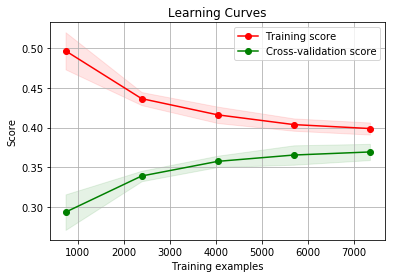

In [45]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_learning_curve(dtree_clf, title, train_features_matrix, train_label_matrix, cv=cv, n_jobs=4, fig_name='cross_validation_learning_curve_dtree')

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()
plt.close()

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_learning_curve(svm_clf, title, train_features_matrix, train_label_matrix,
                    cv=cv, n_jobs=4, fig_name='cross_validation_learning_curve_svm')
plt.show()
plt.close()

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
plot_learning_curve(nn_clf, title, train_features_matrix, train_label_matrix,
                    cv=cv, n_jobs=4, fig_name='cross_validation_learning_curve_nn')
plt.show()
plt.close()